# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import seaborn as sns

# sns.set_theme(palette = 'gist_heat_r')
# sns.set_theme(palette = 'ocean_r')
sns.set_theme(palette = 'dark')


import itertools

In [2]:
bit_csv = "bitstampUSD_1-min_data_2012-01-01_to_2020-12-31.csv"
bit_hist = pd.read_csv(bit_csv)

# Data Exploration

In [3]:
list(bit_hist.columns)

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume_(BTC)',
 'Volume_(Currency)',
 'Weighted_Price']

In [4]:
bit_hist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727777 entries, 0 to 4727776
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 288.6 MB


In [5]:
bit_hist.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.727777e+06,3.484305e+06,3.484305e+06,3.484305e+06,3.484305e+06,3.484305e+06,3.484305e+06,3.484305e+06
mean,1.467409e+09,4.570658e+03,4.573721e+03,4.567413e+03,4.570624e+03,9.422676e+00,3.315691e+04,4.570625e+03
std,8.203749e+07,4.775105e+03,4.778620e+03,4.771352e+03,4.775094e+03,3.101255e+01,1.129107e+05,4.775090e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.396235e+09,4.321900e+02,4.324300e+02,4.320000e+02,4.322000e+02,3.917811e-01,4.147936e+02,4.321753e+02
50%,1.467540e+09,3.085010e+03,3.093250e+03,3.078010e+03,3.084410e+03,1.936719e+00,3.305199e+03,3.085478e+03
75%,1.538456e+09,8.158010e+03,8.162850e+03,8.152790e+03,8.157310e+03,7.299825e+00,2.158297e+04,8.157964e+03
max,1.609373e+09,2.899738e+04,2.901032e+04,2.896366e+04,2.899738e+04,5.853852e+03,1.044599e+07,2.898589e+04


# Preprocessing

In [6]:
bit_hist['Timestamp'] = pd.to_datetime(bit_hist['Timestamp'],unit='s')
bit_hist.set_index('Timestamp', inplace = True)

In [7]:
wp = bit_hist['Weighted_Price']

wp_day = wp.resample('D').mean()
wp_day.freq = 'D'

wp_month = wp.resample('M').mean()
wp_month.freq = 'M'
wp_day = wp_month
wp_day.freq = 'M'


wp_yr = wp.resample('A-DEC').mean()
wp_yr.freq = 'A-Dec'

In [8]:
wp.to_csv('bitcoin_min_series')
wp_day.to_csv('bitcoin_day_series')
wp_month.to_csv('bitcoin_mo_series')

In [9]:
# list of all time period partitions
all_periods = [wp, wp_day, wp_month, wp_yr]
# print lengths of each time period partition
for period in all_periods:
    print(len(period))

4727777
109
109
10


In [10]:
# TimeSeries, String, String, String -> Plot
# Returns a histogram of given time series
def quick_hist(ts, title, xlabel, ylabel):
    plt.plot(ts.index, ts)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.show()

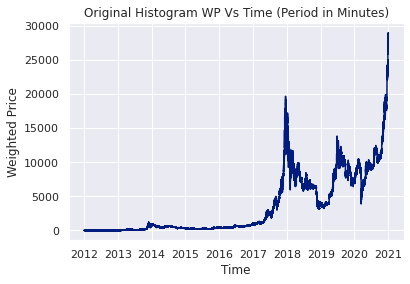

In [11]:
quick_hist(wp, 'Original Histogram WP Vs Time (Period in Minutes)', 'Time', 'Weighted Price')

In [12]:
wp_day.dropna(axis = 0, inplace = True)

# Detrending

In [13]:
min_to_day = 60*24
min_to_week = min_to_day*7

### <div style = "color: black; background-color:gray; padding:10px">Sqrt<div>

Dickey–Fuller test: p=0.973437


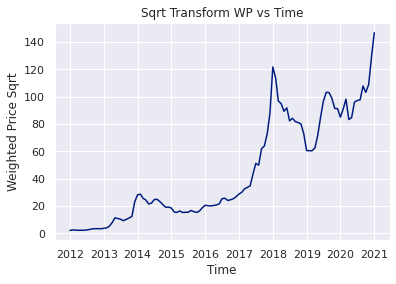

In [14]:
wp_sqrt = np.sqrt(wp_day)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(wp_sqrt)[1])
quick_hist(wp_sqrt, 'Sqrt Transform WP vs Time', 'Time', 'Weighted Price Sqrt')

### <div style = "color: black; background-color:gray; padding:20px">Log<div>

Dickey–Fuller test: p=0.596177


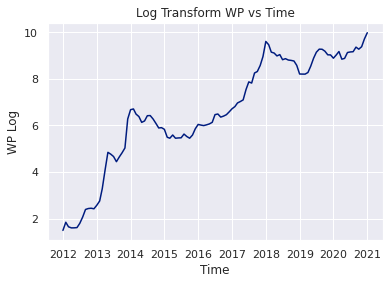

In [15]:
wp_log = np.log(wp_day)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(wp_log)[1])

quick_hist(wp_log, 'Log Transform WP vs Time', 'Time', 'WP Log')

### <div style = "color: black; background-color:gray; padding:20px">Rolling Mean <div>


<div style = "color: teal">The log transform seemed to impact the data much more than the Sqrt, so the log-transform will be used</dif>

Dickey–Fuller test: p=0.744298


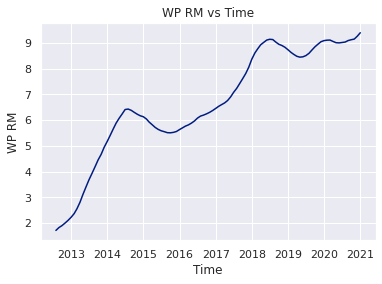

In [16]:
wp_rm = wp_log.rolling(window=8).mean()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(wp_rm.dropna())[1])

quick_hist(wp_rm, 'WP RM vs Time', 'Time', 'WP RM')

# maybe consider FT for actual transform
# quick_test_fun = []
# for i in range(len(wp_rm)):
#     #quick_test_fun.append(2 + i/12)
#     quick_test_fun.append(2+i/12 - 37/50*np.sin(i))
# test_fun = pd.DataFrame(np.array(wp_rm))
# test_fun['test_fun'] = quick_test_fun
# print(test_fun.head())

# plt.plot(test_fun)
# plt.show()

### <div style = "color: black; background-color:gray; padding:20px">Rolling Mean  Subtraction<div>

Dickey–Fuller test: p=0.002898


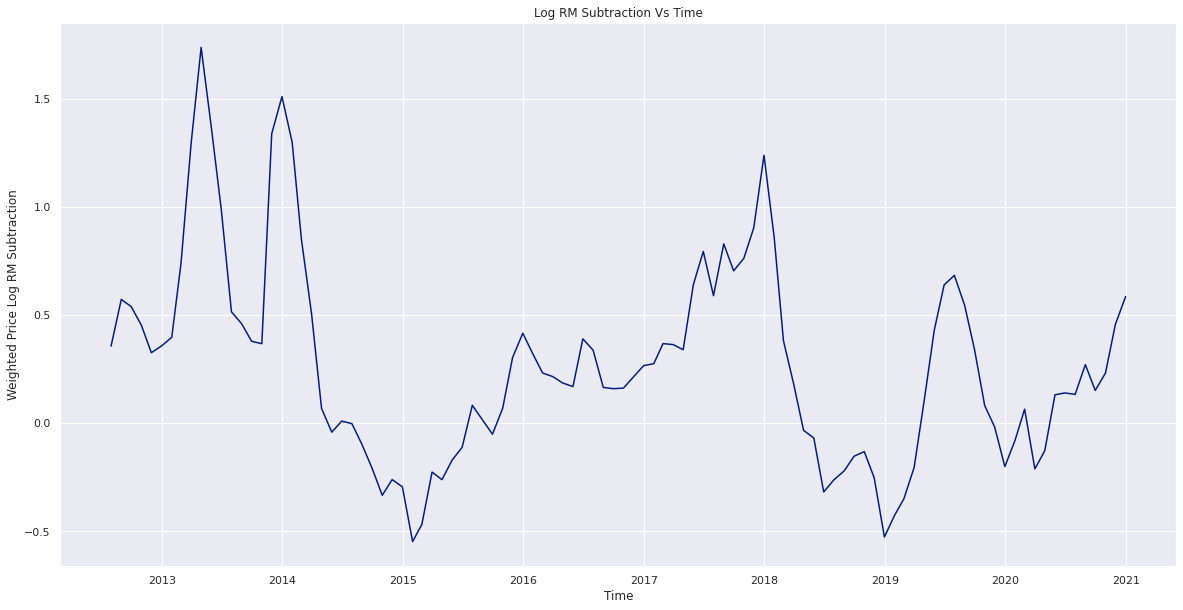

In [17]:
wp_rm_sub = wp_log - wp_rm#quick_test_fun
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(wp_rm_sub.dropna())[1])
fig = plt.figure(figsize = (20, 10))
plt.plot(wp_day.index, wp_rm_sub)
plt.title('Log RM Subtraction Vs Time')
plt.xlabel('Time')
plt.ylabel('Weighted Price Log RM Subtraction')

plt.show()

<div style = "color:teal"> A new stationarity check can be run at this point as there appears no obvious pattern left.<br><br>
Recall the current transformations are :<ul>
    <li>Log-Transform</li>
    <li>Subtraction of rolling mean</li>
    </ul>
</div>

In [18]:
wp_day

Timestamp
2011-12-31        4.471603
2012-01-31        6.345955
2012-02-29        5.228443
2012-03-31        4.984397
2012-04-30        4.995091
                  ...     
2020-08-31    11637.963222
2020-09-30    10656.147579
2020-10-31    11844.141987
2020-11-30    16535.990325
2020-12-31    21576.147253
Freq: M, Name: Weighted_Price, Length: 109, dtype: float64

In [19]:
wp_diff = wp_rm_sub.dropna()

<div style = "color:teal">This is a very low p-value and now the data is ready for modeling</div>

# Reverse Transform Test

In [20]:
# Specific transformed data set -> Original data set
# converts a specific type of transformed data sat back to the original scale/values
def rev_trans(ds):
    rev_t_one = ds + wp_rm.dropna()
    rev_t_two = np.exp(rev_t_one)
    return rev_t_two

#reverse transform test
rtt = rev_trans(wp_rm_sub)

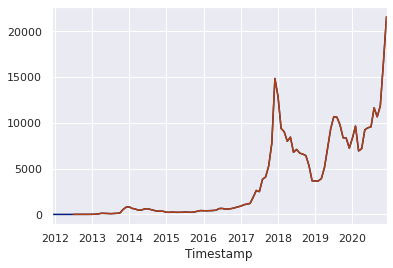

In [21]:
wp_day.plot()
rtt.plot()
plt.show()

---

# Autocorrelation

In [22]:
wp_trans = wp_diff
# wp_trans.index = pd.DatetimeIndex(wp_trans.index).to_period('D')
wp_trans.index = pd.DatetimeIndex(wp_trans.index).to_period('M')

In [23]:
wp_trans.to_csv('bitcoin_transformed')

In [24]:
# sample_size = round(len(wp_diff)*.05)
# sampled = wp_diff.sample(n=sample_size).sort_index()

In [25]:
# plt.plot(wp_trans)

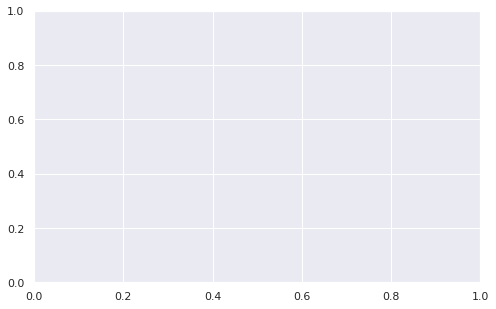

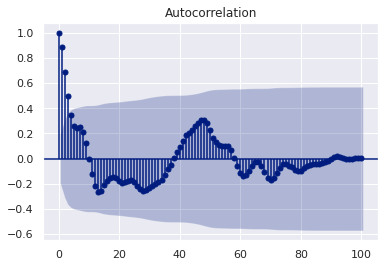

In [26]:
fig, ax = plt.subplots(figsize=(8,5))
plot_acf(wp_trans, lags=100)
plt.show()

# SARIMA

In [27]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

In [28]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(wp_trans, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3425      0.468      0.732      0.464      -0.575       1.260
ma.L1         -0.1031      0.491     -0.210      0.834      -1.065       0.859
ar.S.L12      -0.4084      0.076     -5.378      0.000      -0.557      -0.260
ma.S.L12      -0.4348      0.140     -3.103      0.002      -0.709      -0.160
sigma2         0.0391      0.008      4.848      0.000       0.023       0.055


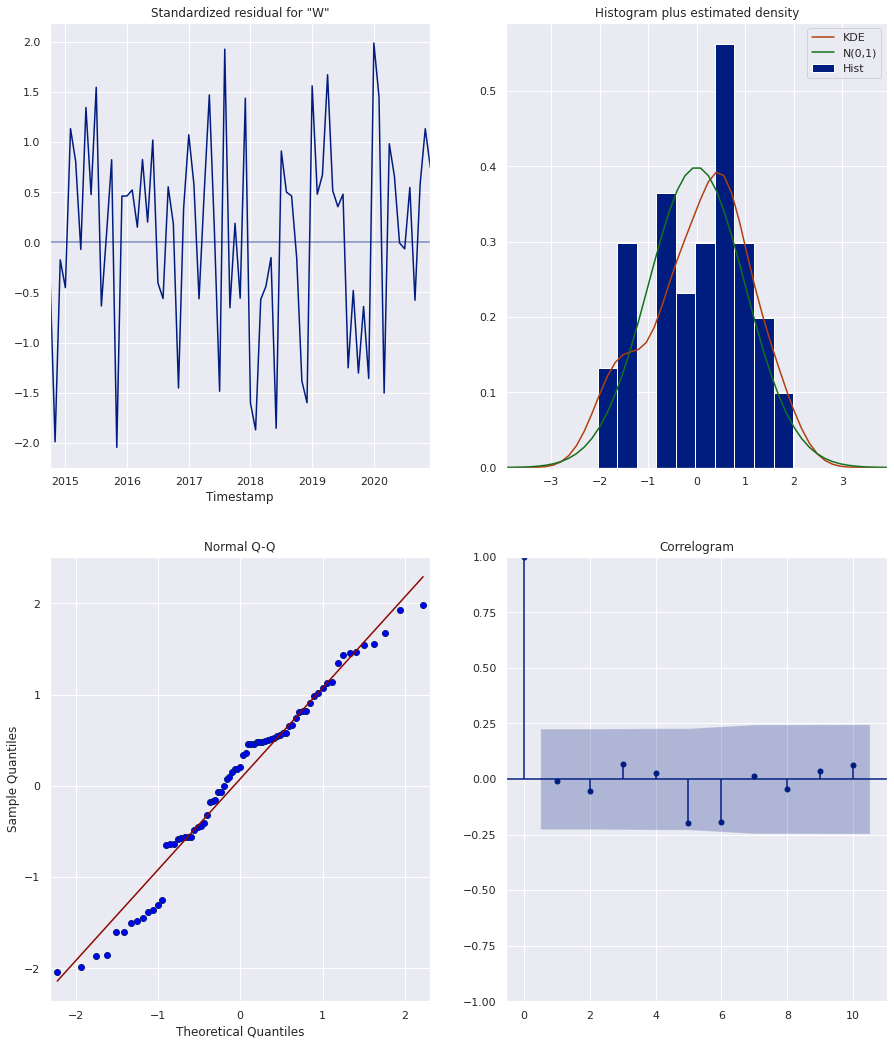

In [29]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [30]:
wp_trans.tail()

Timestamp
2020-08    0.269741
2020-09    0.150748
2020-10    0.230802
2020-11    0.455898
2020-12    0.584462
Freq: M, Name: Weighted_Price, dtype: float64

In [31]:
pred_date = '2020-01-31'
hist_date = '2018'

# Static Model

In [32]:
# Get predictions
pred = output.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)


pred_conf = pred.conf_int()

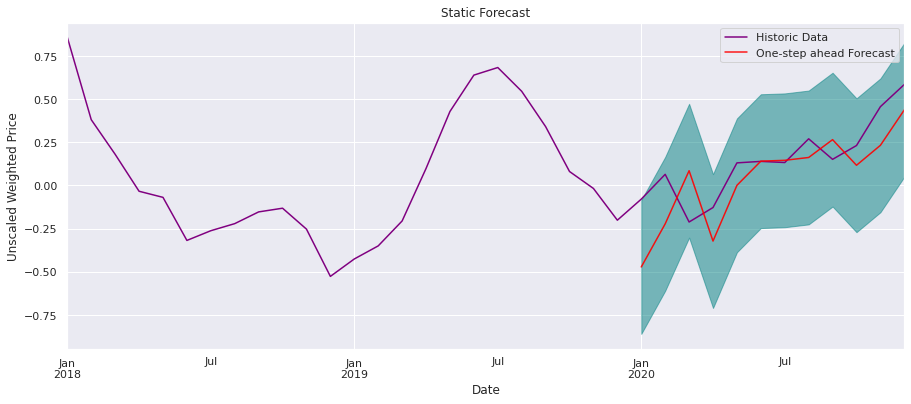

In [33]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = wp_trans[hist_date:].plot(label='Historic Data', color='purple')

# Plot predicted values
pred_mean = pred.predicted_mean
pred_mean.plot(ax=ax, label='One-step ahead Forecast',color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='teal', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Unscaled Weighted Price')
plt.title('Static Forecast')
plt.legend()
plt.show()

In [34]:
# Extract the predicted and true values of our time series
wp_forecasted = pred.predicted_mean
wp_actual = wp_trans[pred_date:]

# Compute the mean square error
mse = ((wp_forecasted - np.array(wp_actual)) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.04


/home/steve/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


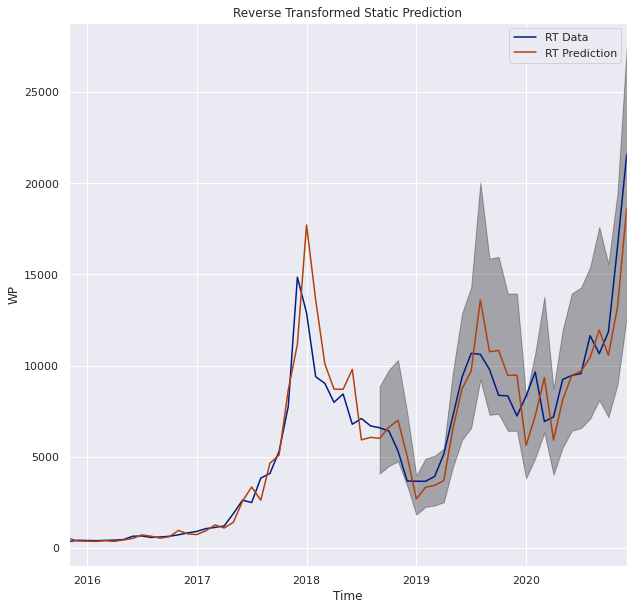

In [35]:
wp_rev_trans = rev_trans(wp_trans)

pred_static_2 = output.get_prediction(start=pd.to_datetime('2012-07'), dynamic=False)
pred_static_2_mean = pred_static_2.predicted_mean
rev_trans_pred = rev_trans(pred_static_2_mean)

static_inf = pred_static_2.conf_int() 
sci_lower = static_inf['lower Weighted_Price']
sci_upper = static_inf['upper Weighted_Price']
sci_lower_t = rev_trans(sci_lower)
sci_upper_t = rev_trans(sci_upper)


sci_lower_final = sci_lower_t.iloc[74:]
sci_upper_final = sci_upper_t.replace(np.inf,np.nan).dropna()[60:]

fig = plt.figure(figsize = (10, 10))
ax = wp_rev_trans.iloc[40:].plot()
rev_trans_pred.iloc[40:].plot(ax=ax)
ax.fill_between(static_inf.index[len(static_inf)-28:],
                sci_lower_final,
                sci_upper_final, color='black', alpha=0.3)

plt.title('Reverse Transformed Static Prediction')
plt.xlabel('Time')
plt.ylabel('WP')
plt.legend(['RT Data','RT Prediction'])
plt.show()

# Dynamic Model

In [36]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

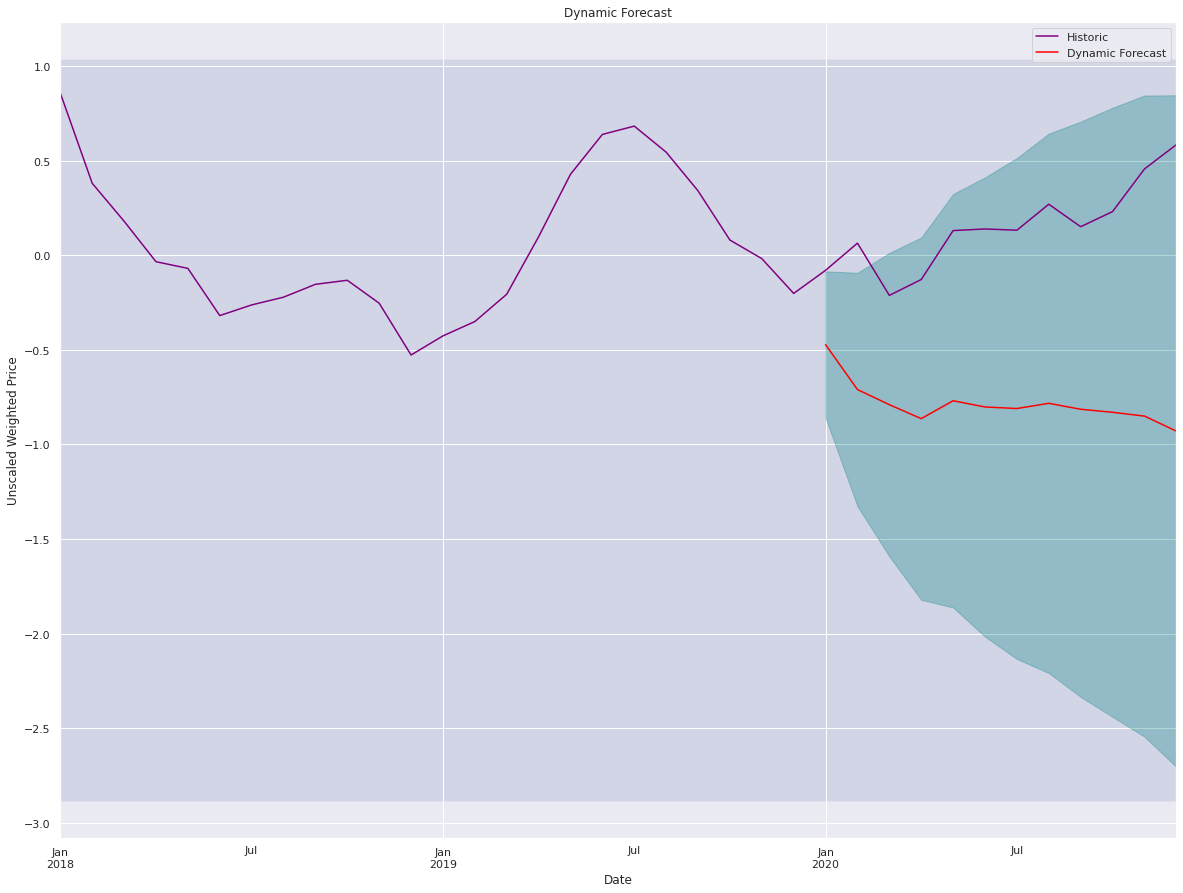

In [37]:
# Plot the dynamic forecast with confidence intervals.

ax = wp_trans[hist_date:].plot(label='Historic', figsize=(20, 15),color='purple')
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax, color='red')

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='teal', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(hist_date), wp_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Unscaled Weighted Price')
plt.title('Dynamic Forecast')
plt.legend()
plt.show()

In [38]:
# Extract the predicted and true values of our time series
wp_forecasted = pred_dynamic.predicted_mean
wp_truth = wp_trans[pred_date:]

# Compute the mean square error
mse = ((wp_forecasted - wp_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.95


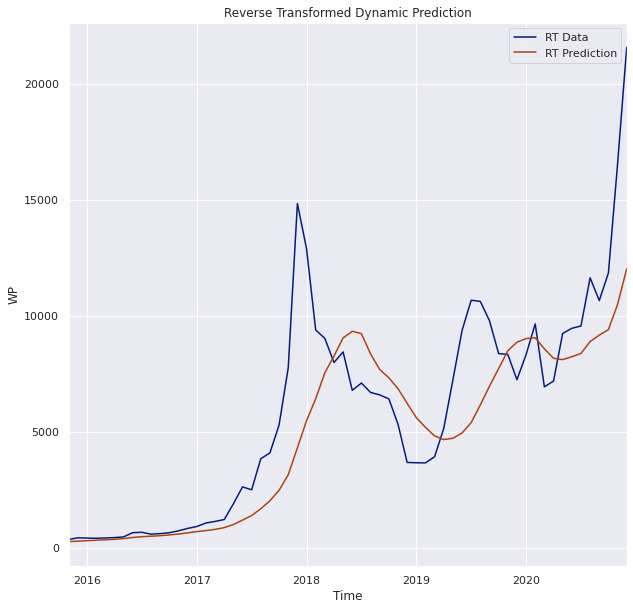

In [39]:
pred_dyn_2 = output.get_prediction(start=pd.to_datetime('2012-07'), dynamic=True)
pred_dyn_2_mean = pred_dyn_2.predicted_mean
rev_trans_pred_dyn = rev_trans(pred_dyn_2_mean)


# dyn_inf = pred_dyn_2.conf_int() 
# dci_lower = dyn_inf['lower Weighted_Price']
# dci_upper = dyn_inf['upper Weighted_Price']
# dci_lower_t = rev_trans(dci_lower)
# dci_upper_t = rev_trans(dci_upper)


# dci_lower_final = dci_lower_t.iloc[74:]
# dci_upper_final = dci_upper_t.replace(np.inf,np.nan).dropna()[60:]


fig = plt.figure(figsize = (10, 10))
ax = wp_rev_trans.iloc[40:].plot()
rev_trans_pred_dyn.iloc[40:].plot(ax=ax)

# ax.fill_between(dyn_inf.index[len(dyn_inf)-28:],
#                 dci_lower[74:],
#                 dci_upper[74:], color='black', alpha=0.3)


plt.title('Reverse Transformed Dynamic Prediction')
plt.xlabel('Time')
plt.ylabel('WP')
plt.legend(['RT Data','RT Prediction'])
plt.show()

# Forecast

In [40]:
# Get forecast 500 steps ahead in future
step = 20
prediction = output.get_forecast(steps=step)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

In [41]:
pred_df = prediction.summary_frame()
pred_mean = pred_df['mean']

In [42]:
pred_mean

2021-01    0.619415
2021-02    0.601347
2021-03    0.593112
2021-04    0.702035
2021-05    0.919811
2021-06    0.993306
2021-07    1.006808
2021-08    0.984125
2021-09    0.868310
2021-10    0.767646
2021-11    0.754159
2021-12    0.664703
2022-01    0.710809
2022-02    0.750441
2022-03    0.629911
2022-04    0.727639
2022-05    0.961771
2022-06    1.008650
2022-07    1.013868
2022-08    1.056589
Freq: M, Name: mean, dtype: float64

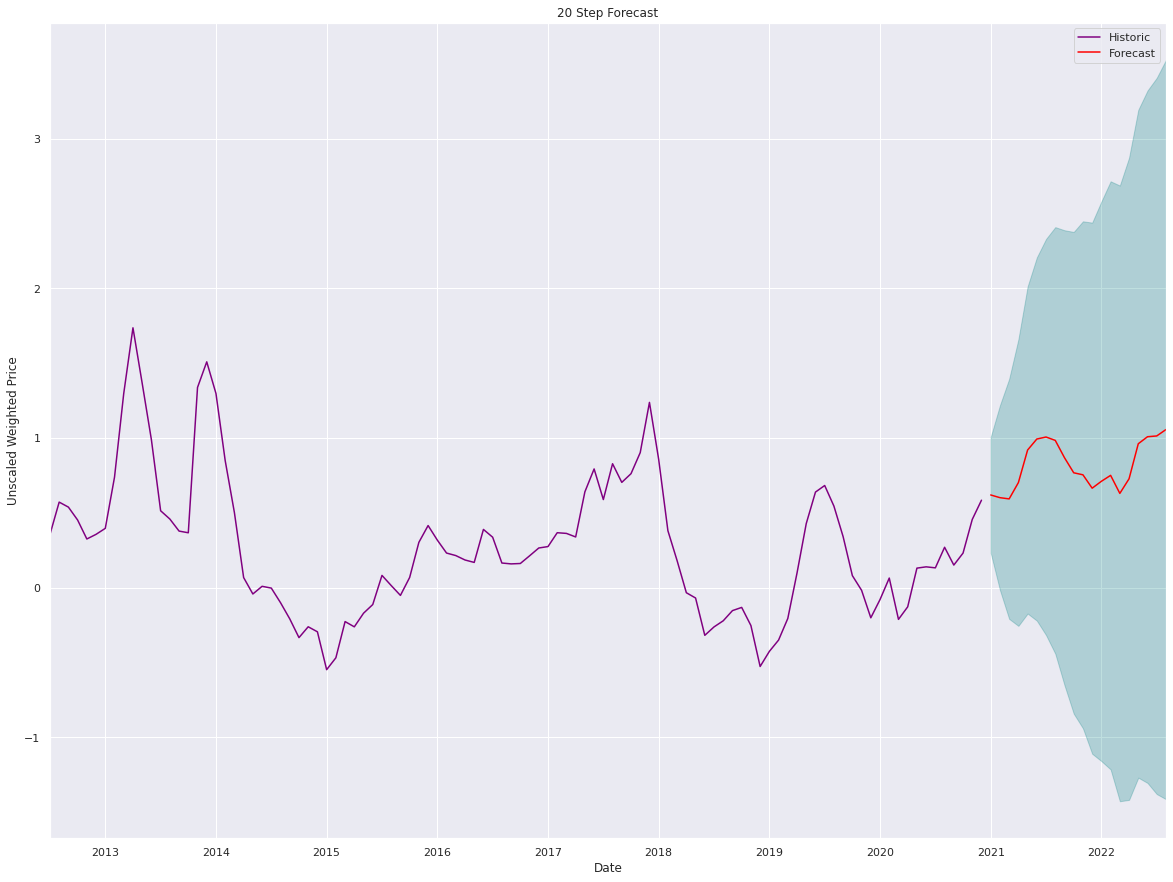

In [43]:
# Plot future predictions with confidence intervals
ax = wp_trans.plot(label='Historic', figsize=(20, 15),color='purple')
prediction.predicted_mean.plot(ax=ax, label='Forecast',color='red')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='teal', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Unscaled Weighted Price')
plt.title(str(step)+' Step ' 'Forecast')
plt.legend()
plt.show()

In [44]:
# Number, Number -> Number
# returns the specific reverse transformation value of value a at differenced value b
def single_val_trans(a,b):
    rev_t_one = a + b
    rev_t_two = np.exp(rev_t_one)
    return rev_t_two

last_trans_val = wp_trans.tail(1).values[0]
one_step_forecast = pred_mean.head(1).values[0]
# the last historic transformed difference value
last_hist_rm = wp_rm.tail(1).values[0]

rt_hist = single_val_trans(last_trans_val, last_hist_rm)
rt_forecast = single_val_trans(one_step_forecast, last_hist_rm)

print('R-T Final historic value:\n', rt_hist, '\n')
print('R-T Forecast value:\n', rt_forecast)

R-T Final historic value:
 21576.147252590246 

R-T Forecast value:
 22343.62443786965


In [78]:
forecast_ind = pred_mean.index
adj = []
for pred in pred_mean:
    adj.append(single_val_trans(pred, last_hist_rm))
adj_forecast = pd.DataFrame(adj,index=forecast_ind)

In [83]:
# Double check the math...also perhaps better mathematical solution could be found
# This applies the average growth to the rolling mean as a correction to the current static transformation value
'''last_hist_w_growth = (wp_rm+wp_rm*((wp_rm-wp_rm.shift(1)).mean())).bfill()
last_hist_w_growth.tail(5)'''

'last_hist_w_growth = (wp_rm+wp_rm*((wp_rm-wp_rm.shift(1)).mean())).bfill()\nlast_hist_w_growth.tail(5)'

In [74]:
def t_form_series_by_pt(ts):
    output = []
    for val in ts:
        output.append(single_val_trans(ts,last_hist_rm)[1])
    return output
pc_ind = pred_conf.index
lower = t_form_series_by_pt(pred_conf['lower Weighted_Price'])
upper = t_form_series_by_pt(pred_conf['upper Weighted_Price'])
t_conf = pd.DataFrame(index=pc_ind)
t_conf['lower Weighted_Price'] = lower
t_conf['upper Weighted_Price'] = upper

In [75]:
t_conf.head()

,lower Weighted_Price,upper Weighted_Price
2021-01,11836.153649,40682.031584
2021-02,11836.153649,40682.031584
2021-03,11836.153649,40682.031584
2021-04,11836.153649,40682.031584
2021-05,11836.153649,40682.031584


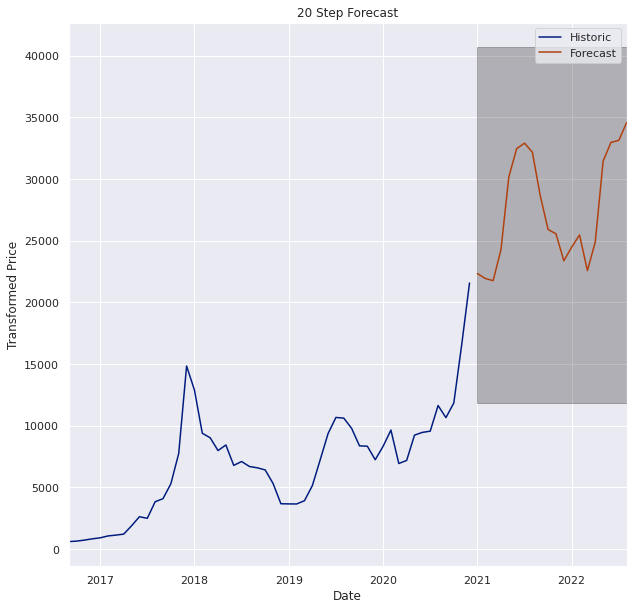

In [76]:
fig = plt.figure(figsize = (10, 10))
ax = wp_rev_trans.iloc[50:].plot()
adj_forecast[0].plot()
ax.fill_between(t_conf.index,
                t_conf.iloc[:, 0],
                t_conf.iloc[:, 1], color='black', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Transformed Price')
plt.title(str(step)+' Step ' 'Forecast')
plt.legend(['Historic','Forecast'])
plt.show()

<div style="color: teal">Note: confidence intervals and forecast are all based on the final (static) value from rolling mean. This means the reverse transformation isn't technically correct; the average growth factor of the rolling mean could be determined and used; due to time constraints this technique has not been applied. </div>

In [77]:
def percent_diff(a,b):
    return 100*(b-a)/a
    # where a is the starting value, and b is the ending value and a,b ∈ |R
    
percent_diff(rt_hist, rt_forecast)

3.5570631600471074

In [50]:
fb_pred = percent_diff(21811.81,14754.04)
print(fb_pred)

-32.35756225641063


# Actual January Weighted Price

In [87]:
import yfinance as yf

In [88]:
btc = yf.Ticker('BTC-USD')
hist = btc.history(period='max', interval='1mo')

In [140]:
actual_jan = hist.iloc[-2]

In [141]:
jan_close = actual_jan['Close']
jan_vol = actual_jan['Volume']

In [142]:
# Timeseries[Close] -> timeseries[WP]
# converts the closing price of a time series to a volume wighted average price
def wp(df_w_close_vol, current_vol):
    WP = (df_w_close_vol.Close.sum() * current_vol)/df_w_close_vol.Volume.sum()
    return WP

In [143]:
wp_jan = wp(hist,jan_vol)

In [144]:
wp_jan 

40325.83596853707

In [146]:
#Percent Change from actual 
percent_diff(rt_hist, wp_jan)

86.90007764799573

In [147]:
rt_hist

21576.147252590246

In [148]:
rt_forecast

22343.62443786965

# Percent Error

In [161]:
# Num, Num -> Percent
# Returns the percent error from a measurement/prediction compared
#    with the actual value
def percent_error(approx, actual):
    return 100*np.abs(approx-actual)/actual

In [156]:
fb_change = -32.36
alt_change = 3.56
actual_change = 86.9

In [162]:
fb_error = percent_error(fb_change, actual_change)
alt_error = percent_error(alt_change, actual_change)

In [163]:
fb_error

137.23820483314154

In [164]:
alt_error

95.90333716915995